In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_targets_t1_normalized_k5_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 1380)
(734160, 1)
validation
(101248, 1380)
(101248, 1)
test
(100432, 1380)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1380)]            0         


 dense (Dense)               (None, 1024)              1414144   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 2103297 (8.02 MB)


Trainable params: 2103297 (8.02 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:27 - loss: 0.0578 - STD: 1.0702e-04 - MAE: 0.2311

 4/74 [>.............................] - ETA: 1s - loss: 0.0307 - STD: 4.7656e-04 - MAE: 0.1342  

 6/74 [=>............................] - ETA: 1s - loss: 0.0300 - STD: 3.9568e-04 - MAE: 0.1336

 8/74 [==>...........................] - ETA: 1s - loss: 0.0278 - STD: 3.1648e-04 - MAE: 0.1249

10/74 [===>..........................] - ETA: 1s - loss: 0.0249 - STD: 2.7109e-04 - MAE: 0.1127

12/74 [===>..........................] - ETA: 1s - loss: 0.0231 - STD: 2.5084e-04 - MAE: 0.1101

14/74 [====>.........................] - ETA: 1s - loss: 0.0224 - STD: 2.3624e-04 - MAE: 0.1114

16/74 [=====>........................] - ETA: 1s - loss: 0.0215 - STD: 2.2117e-04 - MAE: 0.1105

18/74 [======>.......................] - ETA: 1s - loss: 0.0205 - STD: 2.0595e-04 - MAE: 0.1066

20/74 [=======>......................] - ETA: 1s - loss: 0.0197 - STD: 1.9231e-04 - MAE: 0.1019

22/74 [=======>......................] - ETA: 1s - loss: 0.0192 - STD: 1.8101e-04 - MAE: 0.0984

24/74 [========>.....................] - ETA: 1s - loss: 0.0188 - STD: 1.7188e-04 - MAE: 0.0955

26/74 [=========>....................] - ETA: 1s - loss: 0.0184 - STD: 1.6471e-04 - MAE: 0.0928

28/74 [==========>...................] - ETA: 1s - loss: 0.0179 - STD: 1.5926e-04 - MAE: 0.0911

30/74 [===========>..................] - ETA: 1s - loss: 0.0176 - STD: 1.5527e-04 - MAE: 0.0903

32/74 [===========>..................] - ETA: 1s - loss: 0.0173 - STD: 1.5226e-04 - MAE: 0.0901

34/74 [============>.................] - ETA: 1s - loss: 0.0170 - STD: 1.4975e-04 - MAE: 0.0897

36/74 [=============>................] - ETA: 1s - loss: 0.0168 - STD: 1.4754e-04 - MAE: 0.0889

38/74 [==============>...............] - ETA: 1s - loss: 0.0165 - STD: 1.4542e-04 - MAE: 0.0877

40/74 [===============>..............] - ETA: 1s - loss: 0.0163 - STD: 1.4356e-04 - MAE: 0.0864

42/74 [================>.............] - ETA: 0s - loss: 0.0161 - STD: 1.4215e-04 - MAE: 0.0853

44/74 [================>.............] - ETA: 0s - loss: 0.0159 - STD: 1.4115e-04 - MAE: 0.0843

46/74 [=================>............] - ETA: 0s - loss: 0.0157 - STD: 1.4065e-04 - MAE: 0.0835

48/74 [==================>...........] - ETA: 0s - loss: 0.0155 - STD: 1.4060e-04 - MAE: 0.0830

50/74 [===================>..........] - ETA: 0s - loss: 0.0154 - STD: 1.4095e-04 - MAE: 0.0827

52/74 [====================>.........] - ETA: 0s - loss: 0.0153 - STD: 1.4149e-04 - MAE: 0.0823

54/74 [====================>.........] - ETA: 0s - loss: 0.0152 - STD: 1.4221e-04 - MAE: 0.0819

56/74 [=====================>........] - ETA: 0s - loss: 0.0150 - STD: 1.4293e-04 - MAE: 0.0813

58/74 [======================>.......] - ETA: 0s - loss: 0.0149 - STD: 1.4391e-04 - MAE: 0.0808

60/74 [=======================>......] - ETA: 0s - loss: 0.0148 - STD: 1.4515e-04 - MAE: 0.0803

62/74 [========================>.....] - ETA: 0s - loss: 0.0147 - STD: 1.4662e-04 - MAE: 0.0798

64/74 [========================>.....] - ETA: 0s - loss: 0.0146 - STD: 1.4843e-04 - MAE: 0.0795

66/74 [=========================>....] - ETA: 0s - loss: 0.0146 - STD: 1.5057e-04 - MAE: 0.0793

68/74 [==========================>...] - ETA: 0s - loss: 0.0145 - STD: 1.5303e-04 - MAE: 0.0791

70/74 [===========================>..] - ETA: 0s - loss: 0.0144 - STD: 1.5559e-04 - MAE: 0.0789

71/74 [===========================>..] - ETA: 0s - loss: 0.0144 - STD: 1.5689e-04 - MAE: 0.0787

74/74 [==============================] - ETA: 0s - loss: 0.0143 - STD: 1.6126e-04 - MAE: 0.0783

74/74 [==============================] - 5s 49ms/step - loss: 0.0143 - STD: 1.6126e-04 - MAE: 0.0783 - val_loss: 0.0145 - val_STD: 2.3281e-04 - val_MAE: 0.0722


Epoch 2/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0123 - STD: 2.7613e-04 - MAE: 0.0683

 3/74 [>.............................] - ETA: 2s - loss: 0.0120 - STD: 2.8567e-04 - MAE: 0.0684

 5/74 [=>............................] - ETA: 2s - loss: 0.0118 - STD: 2.9465e-04 - MAE: 0.0680

 7/74 [=>............................] - ETA: 2s - loss: 0.0118 - STD: 3.0514e-04 - MAE: 0.0682

 9/74 [==>...........................] - ETA: 2s - loss: 0.0119 - STD: 3.1493e-04 - MAE: 0.0685

11/74 [===>..........................] - ETA: 1s - loss: 0.0119 - STD: 3.2528e-04 - MAE: 0.0687

13/74 [====>.........................] - ETA: 1s - loss: 0.0119 - STD: 3.3617e-04 - MAE: 0.0687

15/74 [=====>........................] - ETA: 1s - loss: 0.0119 - STD: 3.4711e-04 - MAE: 0.0686

17/74 [=====>........................] - ETA: 1s - loss: 0.0119 - STD: 3.5903e-04 - MAE: 0.0686

19/74 [======>.......................] - ETA: 1s - loss: 0.0119 - STD: 3.7175e-04 - MAE: 0.0685

21/74 [=======>......................] - ETA: 1s - loss: 0.0119 - STD: 3.8562e-04 - MAE: 0.0687

23/74 [========>.....................] - ETA: 1s - loss: 0.0119 - STD: 4.0063e-04 - MAE: 0.0688

25/74 [=========>....................] - ETA: 1s - loss: 0.0119 - STD: 4.1615e-04 - MAE: 0.0688

27/74 [=========>....................] - ETA: 1s - loss: 0.0119 - STD: 4.3283e-04 - MAE: 0.0689

29/74 [==========>...................] - ETA: 1s - loss: 0.0119 - STD: 4.5056e-04 - MAE: 0.0688

31/74 [===========>..................] - ETA: 1s - loss: 0.0119 - STD: 4.6886e-04 - MAE: 0.0687

33/74 [============>.................] - ETA: 1s - loss: 0.0119 - STD: 4.8877e-04 - MAE: 0.0686

35/74 [=============>................] - ETA: 1s - loss: 0.0119 - STD: 5.1088e-04 - MAE: 0.0687

37/74 [==============>...............] - ETA: 1s - loss: 0.0119 - STD: 5.3471e-04 - MAE: 0.0687

39/74 [==============>...............] - ETA: 1s - loss: 0.0119 - STD: 5.6104e-04 - MAE: 0.0688

41/74 [===============>..............] - ETA: 1s - loss: 0.0119 - STD: 5.8826e-04 - MAE: 0.0688

43/74 [================>.............] - ETA: 0s - loss: 0.0119 - STD: 6.1812e-04 - MAE: 0.0688

45/74 [=================>............] - ETA: 0s - loss: 0.0119 - STD: 6.5084e-04 - MAE: 0.0688

47/74 [==================>...........] - ETA: 0s - loss: 0.0119 - STD: 6.8696e-04 - MAE: 0.0688

49/74 [==================>...........] - ETA: 0s - loss: 0.0119 - STD: 7.2659e-04 - MAE: 0.0689

51/74 [===================>..........] - ETA: 0s - loss: 0.0119 - STD: 7.6960e-04 - MAE: 0.0689

53/74 [====================>.........] - ETA: 0s - loss: 0.0119 - STD: 8.1758e-04 - MAE: 0.0689

55/74 [=====================>........] - ETA: 0s - loss: 0.0119 - STD: 8.6968e-04 - MAE: 0.0688

57/74 [======================>.......] - ETA: 0s - loss: 0.0119 - STD: 9.2862e-04 - MAE: 0.0688

59/74 [======================>.......] - ETA: 0s - loss: 0.0119 - STD: 9.9390e-04 - MAE: 0.0688

61/74 [=======================>......] - ETA: 0s - loss: 0.0119 - STD: 0.0011 - MAE: 0.0688    

64/74 [========================>.....] - ETA: 0s - loss: 0.0118 - STD: 0.0012 - MAE: 0.0687

66/74 [=========================>....] - ETA: 0s - loss: 0.0118 - STD: 0.0013 - MAE: 0.0686

68/74 [==========================>...] - ETA: 0s - loss: 0.0118 - STD: 0.0014 - MAE: 0.0686

70/74 [===========================>..] - ETA: 0s - loss: 0.0118 - STD: 0.0015 - MAE: 0.0685

72/74 [============================>.] - ETA: 0s - loss: 0.0117 - STD: 0.0017 - MAE: 0.0685

74/74 [==============================] - ETA: 0s - loss: 0.0117 - STD: 0.0019 - MAE: 0.0684

74/74 [==============================] - 3s 35ms/step - loss: 0.0117 - STD: 0.0019 - MAE: 0.0684 - val_loss: 0.0129 - val_STD: 0.0075 - val_MAE: 0.0694


Epoch 3/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0106 - STD: 0.0092 - MAE: 0.0648

 3/74 [>.............................] - ETA: 2s - loss: 0.0107 - STD: 0.0101 - MAE: 0.0652

 5/74 [=>............................] - ETA: 2s - loss: 0.0104 - STD: 0.0111 - MAE: 0.0645

 7/74 [=>............................] - ETA: 2s - loss: 0.0102 - STD: 0.0122 - MAE: 0.0638

 9/74 [==>...........................] - ETA: 2s - loss: 0.0100 - STD: 0.0136 - MAE: 0.0630

11/74 [===>..........................] - ETA: 1s - loss: 0.0098 - STD: 0.0152 - MAE: 0.0625

13/74 [====>.........................] - ETA: 1s - loss: 0.0096 - STD: 0.0171 - MAE: 0.0619

15/74 [=====>........................] - ETA: 1s - loss: 0.0093 - STD: 0.0193 - MAE: 0.0609

17/74 [=====>........................] - ETA: 1s - loss: 0.0090 - STD: 0.0218 - MAE: 0.0599

19/74 [======>.......................] - ETA: 1s - loss: 0.0087 - STD: 0.0246 - MAE: 0.0588

21/74 [=======>......................] - ETA: 1s - loss: 0.0084 - STD: 0.0278 - MAE: 0.0577

23/74 [========>.....................] - ETA: 1s - loss: 0.0081 - STD: 0.0313 - MAE: 0.0566

25/74 [=========>....................] - ETA: 1s - loss: 0.0078 - STD: 0.0350 - MAE: 0.0556

27/74 [=========>....................] - ETA: 1s - loss: 0.0076 - STD: 0.0384 - MAE: 0.0545

29/74 [==========>...................] - ETA: 1s - loss: 0.0073 - STD: 0.0418 - MAE: 0.0536

31/74 [===========>..................] - ETA: 1s - loss: 0.0071 - STD: 0.0449 - MAE: 0.0527

33/74 [============>.................] - ETA: 1s - loss: 0.0069 - STD: 0.0474 - MAE: 0.0519

35/74 [=============>................] - ETA: 1s - loss: 0.0067 - STD: 0.0497 - MAE: 0.0513

37/74 [==============>...............] - ETA: 1s - loss: 0.0066 - STD: 0.0518 - MAE: 0.0507

39/74 [==============>...............] - ETA: 1s - loss: 0.0065 - STD: 0.0537 - MAE: 0.0501

41/74 [===============>..............] - ETA: 1s - loss: 0.0063 - STD: 0.0557 - MAE: 0.0496

43/74 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0574 - MAE: 0.0491

45/74 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0589 - MAE: 0.0486

47/74 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0603 - MAE: 0.0482

49/74 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0615 - MAE: 0.0478

51/74 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0626 - MAE: 0.0473

53/74 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0636 - MAE: 0.0470

55/74 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0466

57/74 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0657 - MAE: 0.0463

59/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0666 - MAE: 0.0460

61/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0674 - MAE: 0.0456

64/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0686 - MAE: 0.0452

66/74 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0693 - MAE: 0.0450

68/74 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0700 - MAE: 0.0447

70/74 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0706 - MAE: 0.0445

72/74 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0712 - MAE: 0.0443

74/74 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0719 - MAE: 0.0441

74/74 [==============================] - 3s 35ms/step - loss: 0.0050 - STD: 0.0719 - MAE: 0.0441 - val_loss: 0.0039 - val_STD: 0.0720 - val_MAE: 0.0380


Epoch 4/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0865 - MAE: 0.0410

 3/74 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.0945 - MAE: 0.0407

 5/74 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0898 - MAE: 0.0401

 7/74 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0916 - MAE: 0.0403

 9/74 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0900 - MAE: 0.0394

12/74 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0915 - MAE: 0.0387

14/74 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0920 - MAE: 0.0384

16/74 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0923 - MAE: 0.0380

18/74 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0924 - MAE: 0.0377

20/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0928 - MAE: 0.0375

22/74 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0927 - MAE: 0.0373

24/74 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0372

26/74 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0930 - MAE: 0.0370

28/74 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0934 - MAE: 0.0370

30/74 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0932 - MAE: 0.0368

32/74 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0934 - MAE: 0.0367

34/74 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0934 - MAE: 0.0366

36/74 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0935 - MAE: 0.0365

38/74 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0364

40/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0936 - MAE: 0.0363

42/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0362

44/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0937 - MAE: 0.0361

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0360

48/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0938 - MAE: 0.0359

50/74 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0938 - MAE: 0.0359

52/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0358

54/74 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0357

56/74 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0939 - MAE: 0.0356

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0356

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0355

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0354

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0354

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0353

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0941 - MAE: 0.0353

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0941 - MAE: 0.0352

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0941 - MAE: 0.0352

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0942 - MAE: 0.0351

74/74 [==============================] - 3s 35ms/step - loss: 0.0029 - STD: 0.0942 - MAE: 0.0351 - val_loss: 0.0031 - val_STD: 0.0805 - val_MAE: 0.0349


Epoch 5/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0331

 3/74 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0968 - MAE: 0.0335

 5/74 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0966 - MAE: 0.0333

 7/74 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0967 - MAE: 0.0333

 9/74 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0332

11/74 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.0958 - MAE: 0.0334

13/74 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.0956 - MAE: 0.0333

15/74 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0956 - MAE: 0.0332

17/74 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0333

19/74 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0333

21/74 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0333

23/74 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0333

24/74 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0332

26/74 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0333

28/74 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0332

30/74 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0332

33/74 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0332

35/74 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0331

37/74 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0331

39/74 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0964 - MAE: 0.0331

41/74 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0331

43/74 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0331

45/74 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0331

47/74 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0966 - MAE: 0.0331

49/74 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0966 - MAE: 0.0331

51/74 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0966 - MAE: 0.0331

53/74 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0966 - MAE: 0.0331

55/74 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0331

57/74 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0330

59/74 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0965 - MAE: 0.0331

61/74 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0964 - MAE: 0.0332

63/74 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0331

65/74 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0331

67/74 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0331

69/74 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0964 - MAE: 0.0331

71/74 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0964 - MAE: 0.0331

73/74 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0964 - MAE: 0.0331

74/74 [==============================] - 3s 36ms/step - loss: 0.0026 - STD: 0.0964 - MAE: 0.0331 - val_loss: 0.0030 - val_STD: 0.0815 - val_MAE: 0.0344


Epoch 6/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0962 - MAE: 0.0314

 3/74 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0983 - MAE: 0.0324

 5/74 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.0984 - MAE: 0.0325

 7/74 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0324

 9/74 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0326

11/74 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0326

13/74 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0328

16/74 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0328

18/74 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0333

20/74 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0332

22/74 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0333

24/74 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0333

26/74 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0333

28/74 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0332

30/74 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0332

32/74 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0332

34/74 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0331

36/74 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0331

38/74 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0332

40/74 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0331

42/74 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0331

44/74 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0331

46/74 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0331

48/74 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0331

50/74 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0331

52/74 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0331

54/74 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0332

56/74 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0332

58/74 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0332

60/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0332

62/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0332

64/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0332

66/74 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0332

68/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0332

70/74 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0332

72/74 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0333

74/74 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0333

74/74 [==============================] - 3s 36ms/step - loss: 0.0025 - STD: 0.0968 - MAE: 0.0333 - val_loss: 0.0030 - val_STD: 0.0770 - val_MAE: 0.0339


Epoch 7/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0908 - MAE: 0.0356

 3/74 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.0973 - MAE: 0.0365

 5/74 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0954 - MAE: 0.0356

 7/74 [=>............................] - ETA: 2s - loss: 0.0029 - STD: 0.0960 - MAE: 0.0365

 9/74 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0964 - MAE: 0.0365

11/74 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0963 - MAE: 0.0358

13/74 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0967 - MAE: 0.0357

15/74 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0967 - MAE: 0.0352

17/74 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0969 - MAE: 0.0350

19/74 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0968 - MAE: 0.0346

21/74 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0970 - MAE: 0.0344

23/74 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0970 - MAE: 0.0342

25/74 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0970 - MAE: 0.0340

27/74 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0968 - MAE: 0.0338

29/74 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0968 - MAE: 0.0337

31/74 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0969 - MAE: 0.0336

33/74 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0968 - MAE: 0.0335

35/74 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.0967 - MAE: 0.0335

37/74 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0967 - MAE: 0.0334

39/74 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0966 - MAE: 0.0334

41/74 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0966 - MAE: 0.0333

43/74 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0332

45/74 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0332

47/74 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0332

49/74 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0331

51/74 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0331

54/74 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0330

56/74 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0329

58/74 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0329

60/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0329

62/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0968 - MAE: 0.0329

64/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0328

66/74 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0328

68/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0328

70/74 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0328

72/74 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0327

74/74 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0327

74/74 [==============================] - 3s 36ms/step - loss: 0.0025 - STD: 0.0970 - MAE: 0.0327 - val_loss: 0.0029 - val_STD: 0.0826 - val_MAE: 0.0343


Epoch 8/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0969 - MAE: 0.0314

 3/74 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0999 - MAE: 0.0317

 5/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0997 - MAE: 0.0316

 7/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0993 - MAE: 0.0316

 9/74 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0318

11/74 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0318

13/74 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0318

15/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0318

17/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0318

19/74 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0318

21/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0318

23/74 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0318

25/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0318

27/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0318

29/74 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0318

31/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0318

33/74 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0318

35/74 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0318

37/74 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0318

39/74 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0318

41/74 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0318

43/74 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0319

45/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0319

47/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0320

49/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0320

51/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0320

53/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0320

55/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0320

57/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0320

59/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0320

61/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0319

63/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0319

65/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0320

67/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0320

70/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0319

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0319

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0319

74/74 [==============================] - 3s 38ms/step - loss: 0.0023 - STD: 0.0979 - MAE: 0.0319 - val_loss: 0.0029 - val_STD: 0.0818 - val_MAE: 0.0342


Epoch 9/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0316

 3/74 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0319

 5/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0320

 7/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0319

 9/74 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0320

11/74 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0321

13/74 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0321

15/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0323

17/74 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.0982 - MAE: 0.0324

19/74 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.0981 - MAE: 0.0325

21/74 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0324

23/74 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0323

25/74 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0323

27/74 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0323

29/74 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0324

31/74 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0324

33/74 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0323

35/74 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0322

37/74 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0322

39/74 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0322

41/74 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0322

43/74 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0323

45/74 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0323

47/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0324

49/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0324

51/74 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0324

54/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0325

56/74 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0325

58/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0325

60/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0326

62/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0327

64/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0328

66/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0329

68/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0976 - MAE: 0.0332

70/74 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0975 - MAE: 0.0333

72/74 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0973 - MAE: 0.0333

74/74 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0973 - MAE: 0.0333

74/74 [==============================] - 3s 37ms/step - loss: 0.0025 - STD: 0.0973 - MAE: 0.0333 - val_loss: 0.0029 - val_STD: 0.0817 - val_MAE: 0.0338


Epoch 10/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0977 - MAE: 0.0315

 4/74 [>.............................] - ETA: 1s - loss: 0.0025 - STD: 0.0996 - MAE: 0.0322

 6/74 [=>............................] - ETA: 1s - loss: 0.0025 - STD: 0.0987 - MAE: 0.0320

 8/74 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.0993 - MAE: 0.0321

10/74 [===>..........................] - ETA: 1s - loss: 0.0024 - STD: 0.0986 - MAE: 0.0319

12/74 [===>..........................] - ETA: 1s - loss: 0.0024 - STD: 0.0982 - MAE: 0.0319

14/74 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0318

16/74 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0318

18/74 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0317

20/74 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0317

22/74 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0317

24/74 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0317

26/74 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0316

28/74 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0316

30/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0316

32/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0316

34/74 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0316

36/74 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0316

38/74 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0317

40/74 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0317

42/74 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0316

44/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0317

46/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0317

48/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0316

50/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0317

52/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0317

54/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0317

56/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0317

58/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0317

60/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0317

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0317

64/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0316

66/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0316

68/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0316

70/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0316

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0316

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0316

74/74 [==============================] - 3s 38ms/step - loss: 0.0023 - STD: 0.0980 - MAE: 0.0316 - val_loss: 0.0030 - val_STD: 0.0831 - val_MAE: 0.0354


Epoch 11/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0315

 3/74 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0316

 5/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0316

 7/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0991 - MAE: 0.0315

 9/74 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0315

11/74 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0316

13/74 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

15/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

17/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

20/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0315

22/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0316

24/74 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0315

26/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0316

28/74 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0316

30/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0316

32/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0315

34/74 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0316

36/74 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0316

38/74 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0316

40/74 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0317

42/74 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0317

44/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0317

46/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0317

48/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0317

50/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0317

52/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0317

54/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0317

56/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

58/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

60/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0317

64/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0317

66/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0318

68/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0318

70/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0319

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0320

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0320

74/74 [==============================] - 3s 38ms/step - loss: 0.0023 - STD: 0.0983 - MAE: 0.0320 - val_loss: 0.0029 - val_STD: 0.0780 - val_MAE: 0.0335


Epoch 12/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0924 - MAE: 0.0343

 3/74 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0979 - MAE: 0.0354

 5/74 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0950 - MAE: 0.0347

 7/74 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0956 - MAE: 0.0350

 9/74 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0346

11/74 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0342

13/74 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.0968 - MAE: 0.0342

15/74 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0967 - MAE: 0.0339

17/74 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0337

19/74 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0333

21/74 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0333

23/74 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0331

25/74 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0330

27/74 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0329

29/74 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0327

32/74 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0326

34/74 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0325

36/74 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0325

38/74 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0324

40/74 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0323

42/74 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0323

44/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0322

46/74 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0322

48/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0322

50/74 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0322

52/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0321

54/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0321

56/74 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0321

58/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0321

60/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0321

62/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0321

64/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0320

66/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0320

68/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0320

70/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0320

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0320

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0320

74/74 [==============================] - 3s 37ms/step - loss: 0.0023 - STD: 0.0979 - MAE: 0.0320 - val_loss: 0.0030 - val_STD: 0.0831 - val_MAE: 0.0350


Epoch 13/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0316

 3/74 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0318

 5/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0315

 7/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

 9/74 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0317

11/74 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0317

13/74 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0316

15/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0316

17/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

19/74 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

21/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

23/74 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

26/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0315

28/74 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0315

30/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0315

32/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0315

34/74 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0315

36/74 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0316

38/74 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0316

40/74 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0316

42/74 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0317

44/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0317

46/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0317

48/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0317

50/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0317

52/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0318

54/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0319

56/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0319

58/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0319

60/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0320

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0319

64/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0319

66/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0319

68/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0319

70/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0319

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0319

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0319

74/74 [==============================] - 3s 38ms/step - loss: 0.0023 - STD: 0.0982 - MAE: 0.0319 - val_loss: 0.0029 - val_STD: 0.0815 - val_MAE: 0.0335


Epoch 14/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0948 - MAE: 0.0313

 3/74 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0314

 5/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0312

 7/74 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0312

 9/74 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0312

11/74 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0313

13/74 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0314

15/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0314

17/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0314

19/74 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0316

21/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0316

23/74 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

25/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0317

27/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0317

29/74 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

31/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0316

33/74 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

35/74 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

37/74 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

39/74 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0316

41/74 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

44/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

46/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

48/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

50/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

52/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

54/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

56/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

58/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

60/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0315

64/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

66/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

68/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

70/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0316

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316

74/74 [==============================] - 3s 38ms/step - loss: 0.0023 - STD: 0.0983 - MAE: 0.0316 - val_loss: 0.0034 - val_STD: 0.0851 - val_MAE: 0.0394


Epoch 15/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1000 - MAE: 0.0336

 3/74 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0320

 5/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0320

 7/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0319

 9/74 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0317

11/74 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0317

13/74 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0317

15/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0316

17/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0316

19/74 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0315

21/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0315

23/74 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0315

25/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0315

27/74 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0314

30/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0314

32/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0314

34/74 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315

36/74 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0314

38/74 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0315

40/74 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0315

42/74 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0315

44/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315

46/74 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315

48/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0315

50/74 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0315

52/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315

54/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315

56/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0315

58/74 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315

60/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315

62/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315

64/74 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315

66/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315

68/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315

70/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0315

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0316

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0316

74/74 [==============================] - 3s 38ms/step - loss: 0.0023 - STD: 0.0985 - MAE: 0.0316 - val_loss: 0.0030 - val_STD: 0.0827 - val_MAE: 0.0351


Epoch 16/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0313

 3/74 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0988 - MAE: 0.0345

 5/74 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0998 - MAE: 0.0348

 8/74 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0984 - MAE: 0.0357

10/74 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.0971 - MAE: 0.0353

12/74 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.0972 - MAE: 0.0354

14/74 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.0965 - MAE: 0.0350

16/74 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0967 - MAE: 0.0350

18/74 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0971 - MAE: 0.0350

20/74 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0972 - MAE: 0.0347

22/74 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0976 - MAE: 0.0345

24/74 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0971 - MAE: 0.0343

26/74 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0973 - MAE: 0.0341

28/74 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0971 - MAE: 0.0339

30/74 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0973 - MAE: 0.0338

32/74 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0336

34/74 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0973 - MAE: 0.0335

36/74 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0973 - MAE: 0.0334

38/74 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0973 - MAE: 0.0333

40/74 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0974 - MAE: 0.0333

42/74 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0973 - MAE: 0.0332

44/74 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0975 - MAE: 0.0331

46/74 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0974 - MAE: 0.0330

48/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0330

50/74 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0329

52/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0328

54/74 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0328

56/74 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0327

58/74 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0327

60/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0326

62/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0326

64/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0325

66/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0325

68/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0325

70/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0324

72/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0324

74/74 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0324

74/74 [==============================] - 3s 38ms/step - loss: 0.0024 - STD: 0.0978 - MAE: 0.0324 - val_loss: 0.0029 - val_STD: 0.0831 - val_MAE: 0.0342


Epoch 17/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.1007 - MAE: 0.0317

 3/74 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0314

 5/74 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0312

 7/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0313

 9/74 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0312

11/74 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0312

13/74 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0312

15/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0311

17/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0312

19/74 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0312

21/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0312

23/74 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0312

25/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0312

27/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0312

29/74 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0312

31/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0991 - MAE: 0.0312

33/74 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0312

35/74 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0312

37/74 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0312

39/74 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0312

41/74 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0312

43/74 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0312

45/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0312

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0312

51/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

53/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

59/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

63/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

65/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

69/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

71/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0312

74/74 [==============================] - 3s 38ms/step - loss: 0.0022 - STD: 0.0987 - MAE: 0.0312 - val_loss: 0.0030 - val_STD: 0.0834 - val_MAE: 0.0353


Epoch 18/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1004 - MAE: 0.0310

 4/74 [>.............................] - ETA: 1s - loss: 0.0023 - STD: 0.1002 - MAE: 0.0316

 6/74 [=>............................] - ETA: 1s - loss: 0.0023 - STD: 0.1003 - MAE: 0.0317

 8/74 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1000 - MAE: 0.0315

10/74 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.0999 - MAE: 0.0315

12/74 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.0998 - MAE: 0.0316

14/74 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0315

16/74 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0316

18/74 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0316

20/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0316

22/74 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0315

24/74 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0315

26/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0315

28/74 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0315

30/74 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0315

32/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0314

34/74 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0991 - MAE: 0.0314

36/74 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0314

38/74 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0314

40/74 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0314

42/74 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0314

44/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0314

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0314

48/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0314

50/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0313

54/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

56/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0314

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313

74/74 [==============================] - 3s 38ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0313 - val_loss: 0.0029 - val_STD: 0.0819 - val_MAE: 0.0343


Epoch 19/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0312

 3/74 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0970 - MAE: 0.0316

 5/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0316

 7/74 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0314

 9/74 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0313

11/74 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0314

13/74 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313

15/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313

17/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0313

19/74 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0312

21/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0313

24/74 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0312

26/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0311

28/74 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0312

30/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0312

32/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0312

34/74 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0312

36/74 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0312

38/74 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0312

40/74 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0312

42/74 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0312

44/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0312

46/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

48/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

50/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313

52/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0314

54/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0314

56/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0314

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0314

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0314

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0314

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0314

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0314

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0314

70/74 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0315

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0315

74/74 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0315

74/74 [==============================] - 3s 38ms/step - loss: 0.0023 - STD: 0.0987 - MAE: 0.0315 - val_loss: 0.0031 - val_STD: 0.0846 - val_MAE: 0.0362


Epoch 20/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0304

 3/74 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0307

 5/74 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0311

 7/74 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0311

 9/74 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0310

11/74 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0311

13/74 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0312

15/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0311

17/74 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0312

19/74 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0312

21/74 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313

23/74 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0312

25/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313

27/74 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313

29/74 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313

31/74 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313

33/74 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0313

35/74 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0313

37/74 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0313

39/74 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0983 - MAE: 0.0313

41/74 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0313

43/74 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0313

45/74 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0314

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0313

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313

51/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

53/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0314

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0314

59/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0314

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0313

63/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0314

65/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0313

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313

74/74 [==============================] - 3s 38ms/step - loss: 0.0022 - STD: 0.0986 - MAE: 0.0313 - val_loss: 0.0029 - val_STD: 0.0824 - val_MAE: 0.0339


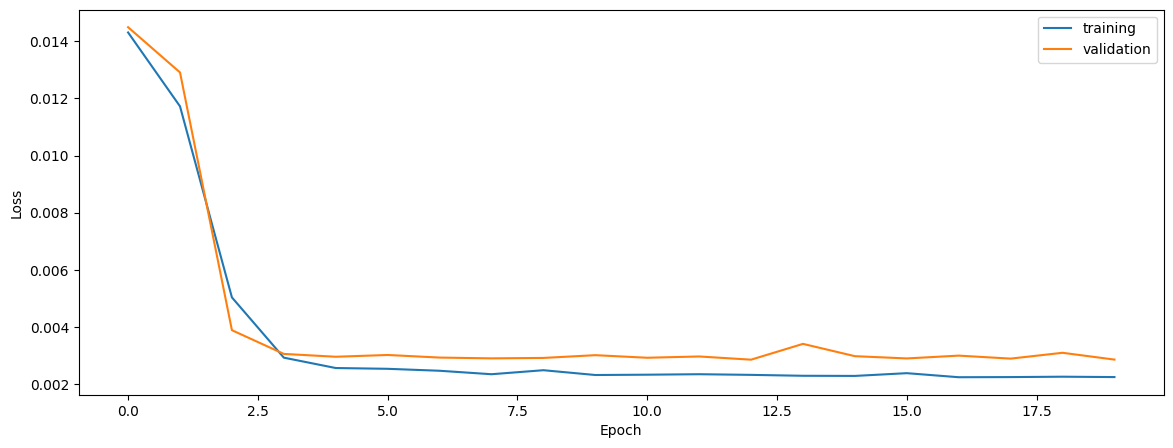

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9011010349413199
0.8971652356125286
0.9118173034089072


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9011010349413199
0.8971652356125286
0.9118173034089072


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9038991030586715
0.9081122833578898
0.9218451898845207


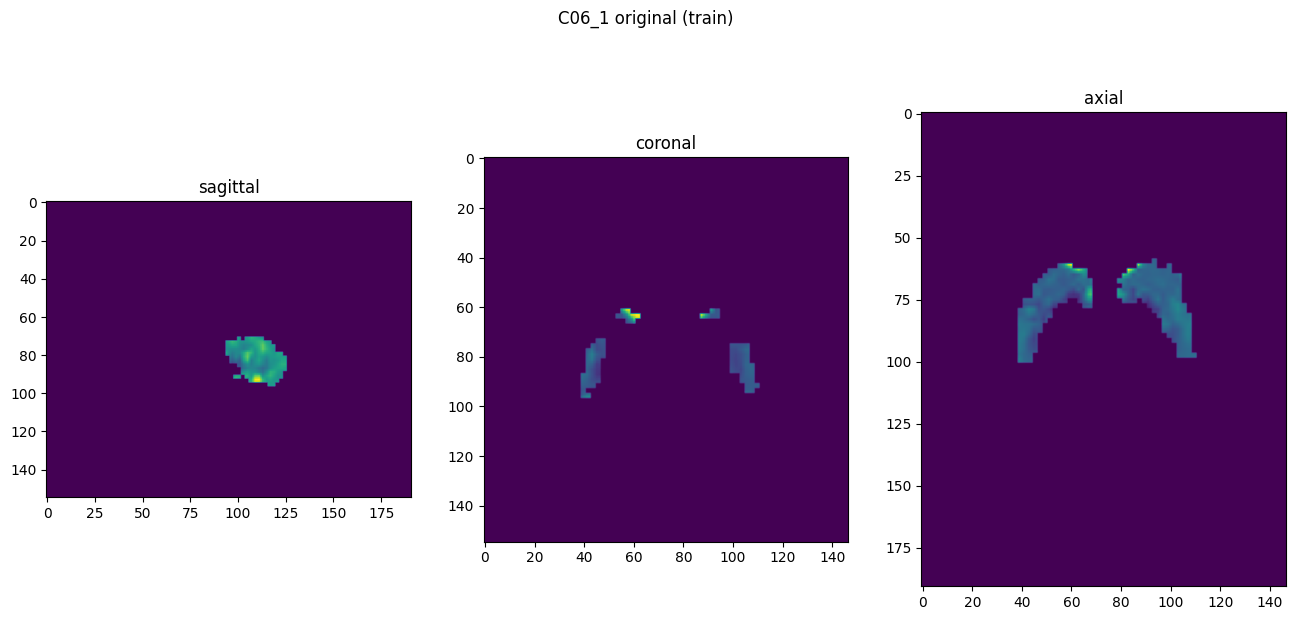

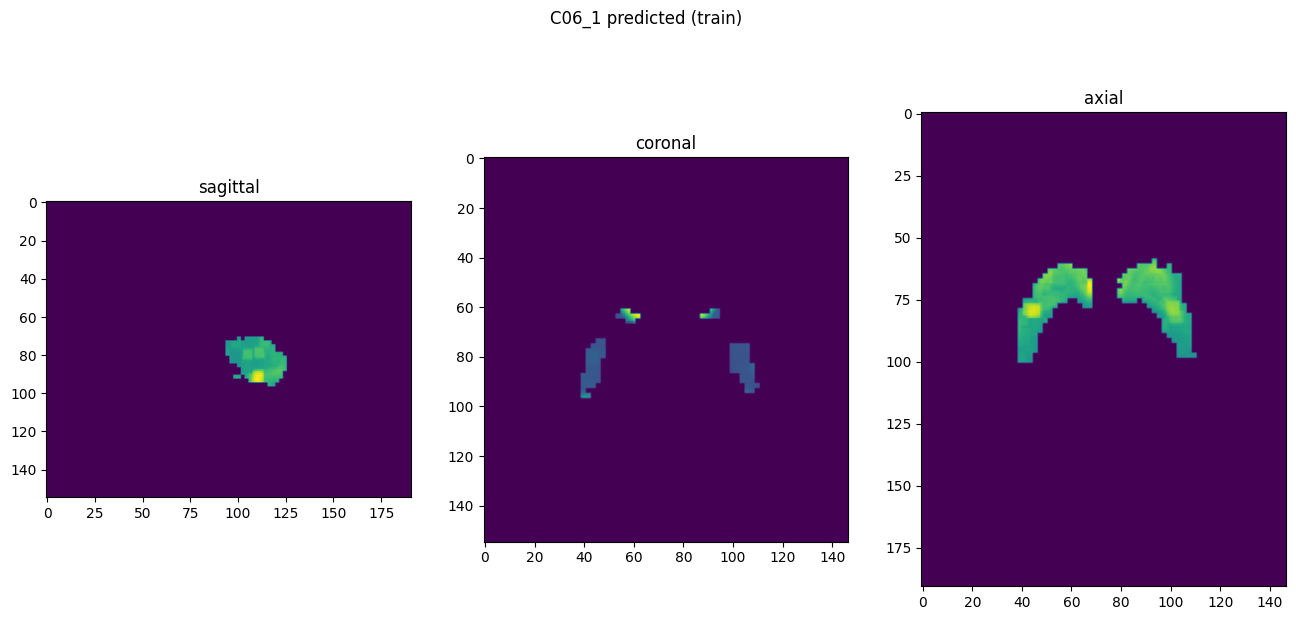

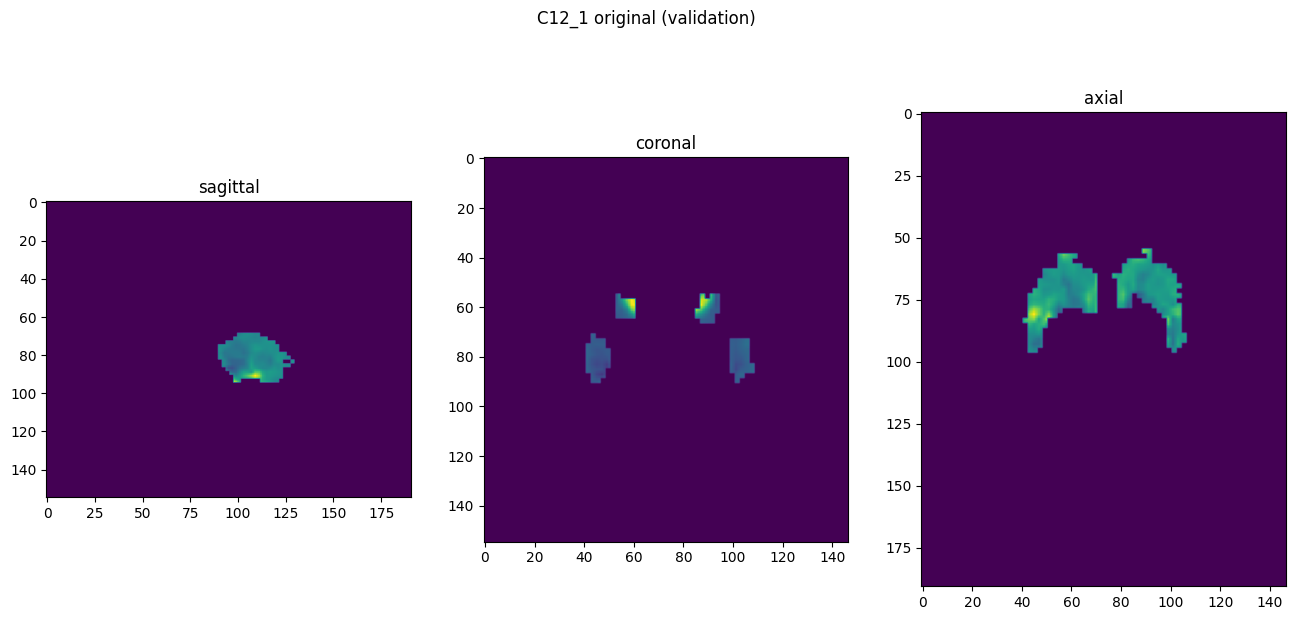

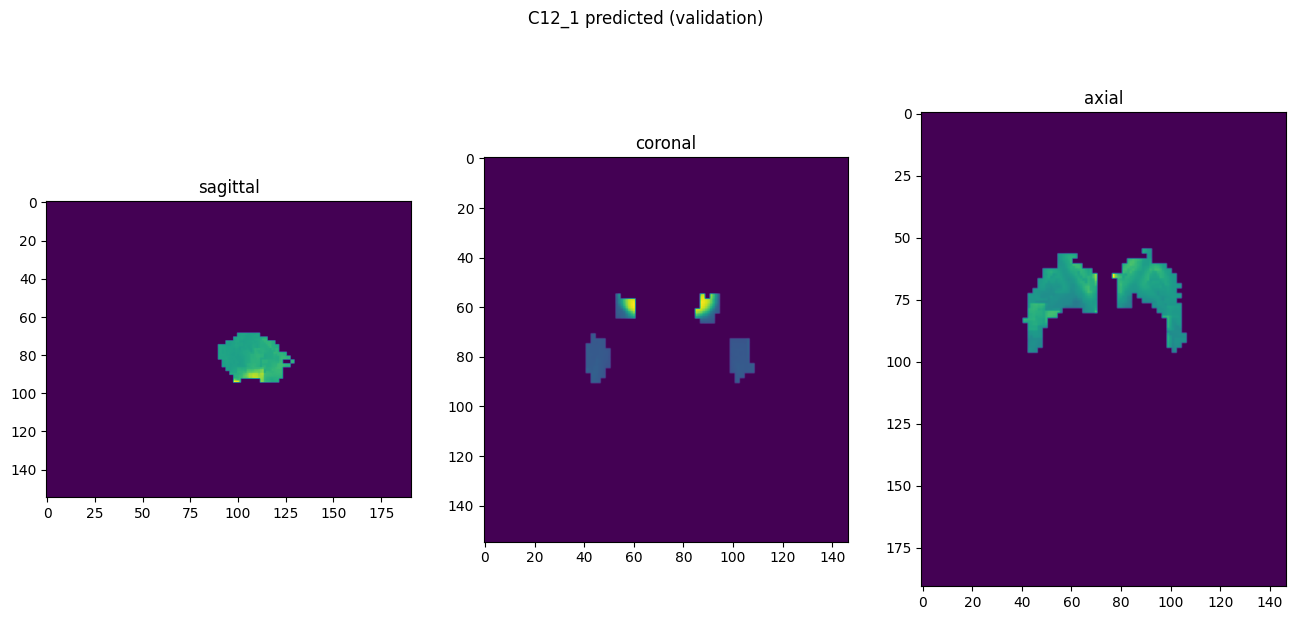

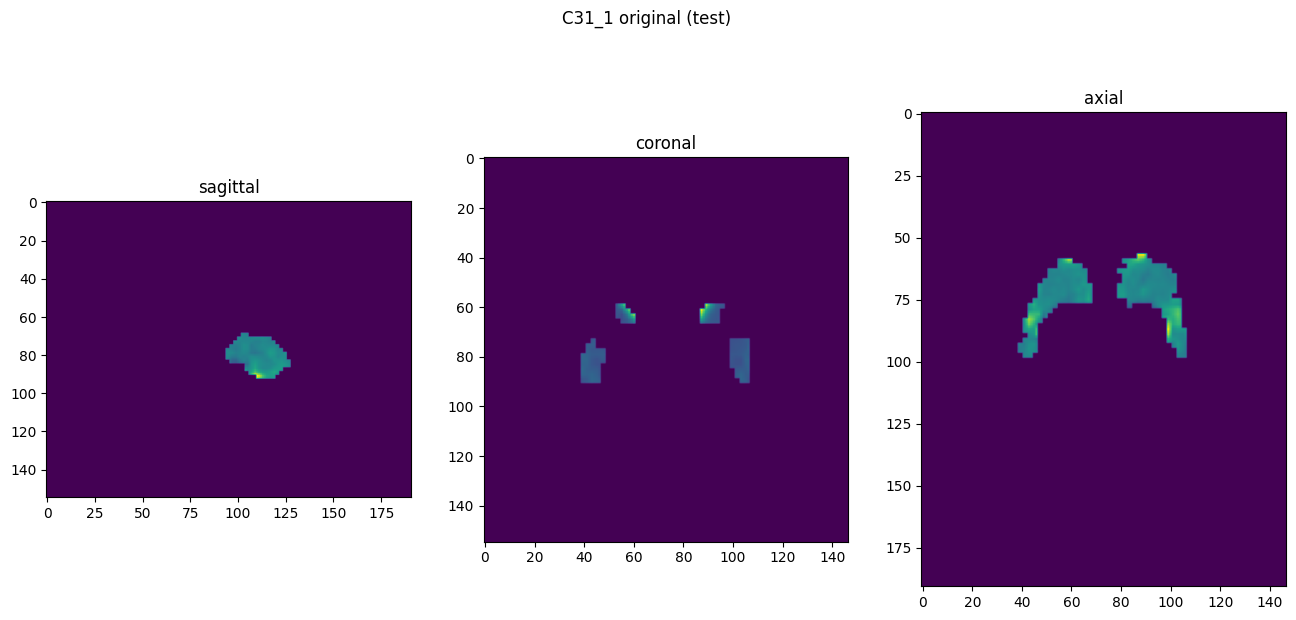

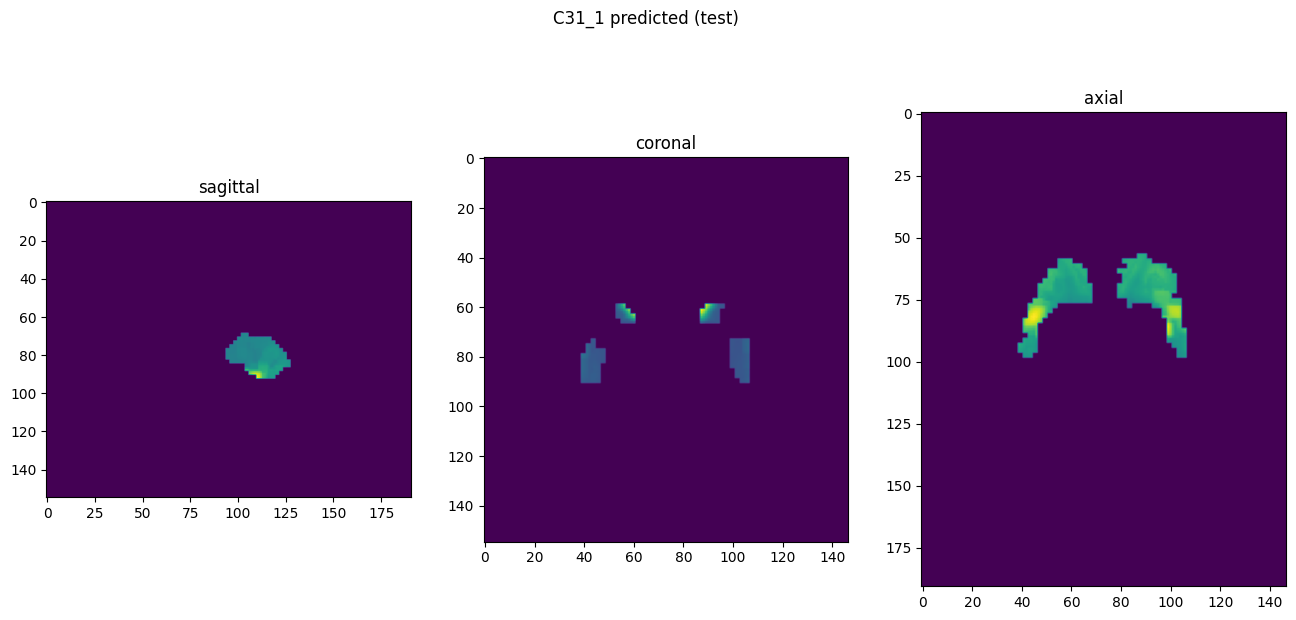

In [10]:
showResults(model, gen, threshold=None, background=False)